# G-formula: Monte Carlo Estimator
In this tutorial, we will again review the Monte-Carlo g-formula. In this tutorial, we will replicate the results from Keil AP et al. (2014). The parametric G-formula for time-to-event data: towards intuition with a worked example. *Epidemiology*, 25(6), 889. I highly recommend reading the paper and following along with the paper. Additionally, the original paper has SAS code available for comparison. The paper can be found [HERE](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4310506/) and the SAS code can be found [HERE](https://github.com/alexpkeil1/Gformula-tutorial)

## Estimand
In the original paper, the authors were interested in the average causal effect comparing the prevention of all graph-versus-host-disease (GvHD) to the natural course. Due to time-varying confounding, the authors chose to use the g-formula. 

More generally, all of Robins' g-methods allow for time-varying confounding. Each of the method has various advantages/disadvantages. See the other tutorials for other methods (marginal structural models estimated with inverse-probability-of-treatment-weights and g-estimation of structural nested models)

## Parametric G-formula
Due to the high dimensional of the data, the authors needed to use the parametric g-formula. Essentially, we specify regression models from our data set. We use the data sets to simulate (or impute) potential outcomes under our treatment strategies. So, which variables need to have regression models specified? We will need to specify regression models for each time-varying confounder. We will use a large resample of population to simulate the potential outcomes. We use a large number to reduce simulation error.

## Data
Before proceeding, we will load the corresponding data set. The data set comes with *zEpid* and can be loaded by the `load_gvhd_data()` function

In [1]:
import numpy as np
import pandas as pd
from lifelines import KaplanMeierFitter, CoxPHFitter
import matplotlib.pyplot as plt
% matplotlib inline

from zepid import load_gvhd_data

df = load_gvhd_data()
df['tomorrow'] = df['day']+1
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108714 entries, 0 to 108849
Data columns (total 30 columns):
id                108714 non-null float64
age               108714 non-null float64
agesq             108714 non-null float64
agecurs1          108714 non-null float64
agecurs2          108714 non-null float64
male              108714 non-null float64
cmv               108714 non-null float64
all               108714 non-null float64
wait              108714 non-null float64
yesterday         108714 non-null int64
tomorrow          108714 non-null int64
day               108714 non-null int64
daysq             108714 non-null int64
daycu             108714 non-null int64
daycurs1          108714 non-null float64
daycurs2          108714 non-null float64
d                 108714 non-null float64
gvhd              108714 non-null int32
relapse           108714 non-null int32
platnorm          108714 non-null int32
gvhdm1            108714 non-null int32
relapsem1         108714 

See the information regarding what the variables correspond to. The key variables are `gvhd` (GvHD), `d` (death), and `day` (current time).

The data set looks like the following

In [2]:
print(df[['id', 'day', 'gvhd', 'd', 'age']].head(10))

     id  day  gvhd    d   age
0   1.0    1     0  1.0  42.0
2   2.0    1     0  0.0  20.0
3   2.0    2     0  1.0  20.0
5   3.0    1     0  0.0  34.0
6   3.0    2     0  0.0  34.0
7   3.0    3     0  0.0  34.0
8   3.0    4     0  0.0  34.0
9   3.0    5     0  0.0  34.0
10  3.0    6     0  0.0  34.0
11  3.0    7     0  0.0  34.0


The data set has a row for each individual for each time unit (day). The data must be formatted in this long-format for `MonteCarloGFormula`. I will now follow along with the 3-step algorithm described in paper.

## Step 0) Initializing the g-formula
Before starting the algorithm process, we will load the `MonteCarloGFormula` class. We initialize the class with the data set (`df`), the variable indicating IDs (`id`), the treatment/exposure (`gvhd`), the outcome (`d`), the 

In [3]:
from zepid.causal.gformula import MonteCarloGFormula

g = MonteCarloGFormula(df,  # pandas dataframe object containing data to fit to
                       idvar='id',  # unique ID for participants
                       exposure='gvhd',  # exposure column label (gvhd)
                       outcome='d',  # outcome column label (d)
                       time_in='day',  # entry time column label
                       time_out='tomorrow')  # exit time column label

## Step 1) Probability Modeling
The first step described by the authors is to fit pooled logistic regression models for each time-varying variables. In this example, we need models for GvHD (`gvhd`), death (`d`), normal platelet count (`platnorm`), probability of relapse (`relapse`), and censoring. Censoring is automatically detected by `MonteCarloGFormula` and codes a new variable

I will break these into pieces. First, let's fit the GvHD model

### Step 1a) GvHD model
We will model GvHD by cytomegalovirus, age, normal platelet count on previous day, days with a normal platelet count, relapsed on previous day, days without relapsing, time, and wait time to transplant. 

Additionally, the authors assumes a intent-to-treat (once an individual developed GvHD, they were considered to have GvHD at all future time points). We can estimate the corresponding model by using the optional `restriction` argument. In the background, the `MonteCarloGFormula` refers to the data set as `g`. I refer to this as the 'magic-g'. We make the restriction using *pandas* notation to subset the data, `g['gvhdm1'] == 0`, meaning the model is only being fit to observations where the previous time point did not have a GvHD diagnosis.

In [4]:
exp_m = ('all + cmv + male + age + agecurs1 + agecurs2 + platnormm1 + '
         'daysnoplatnorm + relapsem1 + daysnorelapse + '
         'day + daysq + wait')
g.exposure_model(exp_m,  # dependent variable model to predict exposure
                 restriction="g['gvhdm1']==0")  # restricting for ITT

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   gvhd   No. Observations:                54617
Model:                            GLM   Df Residuals:                    54603
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -477.60
Date:                Tue, 07 May 2019   Deviance:                       955.20
Time:                        08:17:10   Pearson chi2:                 2.30e+04
No. Iterations:                    19   Covariance Type:             nonrobust
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -7.2506      1.003     -7.226      0.000      -9.217      -5.284
all                0.6005      0.287    

By default, the regression model results will be printed to the console. These can be surpressed by specifying the optional argument `print_results=False`. 

### Step 1b) Outcome model
Next we will specify the outcome model. We will model death as a function of cytomegalovirus, age, time since study start, GvHD, normal platelet count, number of days with a normal platelet count, relapse, days without relapse, waiting time for transplant. We will include an interaction term between time since study start and treatment. These should be included by using *patsy* magic. Specifically, the `:` operator

In [5]:
out_m = ('gvhd + cmv + male + age  + agesq + day + daysq + daycu + platnorm + '
         'daysnoplatnorm + relapse + daysnorelapse + wait + all + '
         'day:gvhd + daysq:gvhd + daycu:gvhd')
g.outcome_model(out_m)  # dependent variable model to predict outcome

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      d   No. Observations:               108714
Model:                            GLM   Df Residuals:                   108696
Model Family:                Binomial   Df Model:                           17
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -565.43
Date:                Tue, 07 May 2019   Deviance:                       1130.9
Time:                        08:17:14   Pearson chi2:                 8.99e+04
No. Iterations:                    13   Covariance Type:             nonrobust
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -7.3353      0.943     -7.777      0.000      -9.184      -5.487
gvhd               0.9856      0.676    

### Step 1c) Normal platelet count model
Next, we will begin the process of estimating time-varying confounding. Again, we will impose a restriction. Specifically, once an individual's platelet count returns to normal, it remains normal. We do this by using the `restriction` argument again

Additionally, we are adding some additional argument. First, we specify `label` which tells `MonteCarloGFormula` when the time-varying confounder should be fit relative to the other time-varying confounders. Second, we specify `recode`. The recode procedure tells the `MonteCarloGFormula` any code it needs to run during the simulation procedure. Specifically, we need to make sure that the days with normal platlet counts is counted correctly. Third, we specify `var_type` indicating whether to use a logitistic regression or linear regression.

In [6]:
# Model specification
prp_m = 'all + cmv + male + age + agecurs1 + agecurs2 + gvhdm1 + daysgvhd + daysnorelapse + wait'

# Specifying recoding process during Monte-Carlo procedure
prp_recode = ("g['platnorm'] = np.where(g['platnormm1']==1, 1 ,g['platnorm']);"
              "g['daysnoplatnorm'] = np.where(g['platnorm']==0, g['daysnoplatnorm']+1, "
                                              "g['daysnoplatnorm']);"
              "g['daysplatnorm'] = np.where(g['platnorm']==0, g['daysplatnorm'], "
                                            "g['daysplatnorm']+1);")

# Adding model
g.add_covariate_model(label=1,  # order to fit the covariate model
                      covariate='platnorm',  # covariate to predict
                      model=prp_m,  # dependent variable model to predict covariate (platnorm)
                      recode=prp_recode,  # recoding process to execute each loop
                      var_type='binary',  # covariate variable type
                      restriction="g['platnormm1']==0")  # restricting for ITT

                 Generalized Linear Model Regression Results                  
Dep. Variable:               platnorm   No. Observations:                 6842
Model:                            GLM   Df Residuals:                     6831
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -535.65
Date:                Tue, 07 May 2019   Deviance:                       1071.3
Time:                        08:17:17   Pearson chi2:                 4.61e+03
No. Iterations:                    13   Covariance Type:             nonrobust
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -5.7715      0.640     -9.025      0.000      -7.025      -4.518
all              -0.0710      0.233     -0.

### Step 1d) Relapse model
Next, we estimate a model for relapse. We will use a similar process and similar arguments as the previous model. We specify this model to be estimated after normal platelet counts are simulated.

In [7]:
# Model specification for relapse
prr_m = ('all + cmv + male + age + agecurs1 + agecurs2 + gvhdm1 +  daysgvhd + platnormm1 + '
         'daysnoplatnorm + day + daysq + wait')

# Recoding procedure for Monte-Carlo process
relapse_recode = ("g['relapse'] = np.where(g['relapsem1']==1,1,g['relapse']);"
                  "g['daysnorelapse'] = np.where(g['relapse']==0, g['daysnorelapse']+1,"
                                                 "g['daysnorelapse']);"
                  "g['daysrelapse'] = np.where(g['relapse']==0, g['daysrelapse'],"
                                              "g['daysrelapse']+1);")

# Estimating model in g-formula
g.add_covariate_model(label=2,  # order to fit the covariate model
                      covariate='relapse',  # covariate to predict
                      model=prr_m,  # dependent variable model to predict covariate (relapse)
                      recode=relapse_recode,  # recoding process to execute each loop
                      var_type='binary',  # covariate variable type
                      restriction="g['relapsem1']==0")  # restricting for ITT

                 Generalized Linear Model Regression Results                  
Dep. Variable:                relapse   No. Observations:               100930
Model:                            GLM   Df Residuals:                   100916
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -345.76
Date:                Tue, 07 May 2019   Deviance:                       691.51
Time:                        08:17:21   Pearson chi2:                 7.56e+04
No. Iterations:                    15   Covariance Type:             nonrobust
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -6.8681      1.308     -5.250      0.000      -9.432      -4.304
all                0.5865      0.391    

### Step 1e) Censoring model
Lastly, we will specify a model for censoring. By doing this, we relax the assumption of un-informative censoring to un-informative censoring conditional on cytomegalovirus, gender, age, days of normal platelets, days of no relapse, time since origin, and time waiting for a transplant

In [8]:
cen_m = ('all + cmv + male + age + agesq + daysgvhd + daysnoplatnorm + '
         'daysnorelapse + day + daysq + daycu + wait')
g.censoring_model(model=cen_m)

                 Generalized Linear Model Regression Results                  
Dep. Variable:         __uncensored__   No. Observations:               108714
Model:                            GLM   Df Residuals:                   108701
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -309.40
Date:                Tue, 07 May 2019   Deviance:                       618.80
Time:                        08:17:25   Pearson chi2:                 8.77e+04
No. Iterations:                    14   Covariance Type:             nonrobust
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          9.8879      2.242      4.409      0.000       5.493      14.283
all               -0.7590      0.448    

## Step 2) Monte Carlo sampling


In [9]:
g.fit(treatment="((g['gvhd']==1) | (g['gvhdm1']==1))",  # treatment strategy (ITT natural course)
      lags={'platnorm': 'platnormm1',  # lagging certain variables at end of each loop
            'relapse': 'relapsem1',
            'gvhd': 'gvhdm1'},
      sample=13700,  # number to resample of population for Monte Carlo
      t_max=1825,  # maximum time to simulate to
      in_recode=("g = g.loc[g['censlost'] == 0].copy();"  # variable recoding to execute at start of loops
                 "g['daysq'] = g['day']**2;"
                 "g['daycu'] = g['day']**3;"),
      out_recode=("g['daysnogvhd'] = np.where(g['gvhd'] == 0, g['daysnogvhd']+1, g['daysnogvhd']);"
                  "g['daysgvhd'] = np.where(g['gvhd'] == 0, g['daysgvhd'], g['daysgvhd']+1);")
     )  # Recoding variables at end of loops

We will now generate a plot comparing the observed risk curve to the natural course predictions from the Monte-Carlo g-formula. Below is code to generate a plot

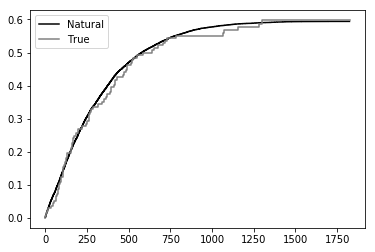

In [15]:
# Fitting Kaplan Meier to Natural Course
gf = g.predicted_outcomes

kmn = KaplanMeierFitter()
kmn.fit(durations=gf['day'], event_observed=gf['d'])

# Fitting Kaplan Meier to Observed Data
df.sort_values(by=['id', 'day'])
dfs = df.loc[df.id != df.id.shift(-1)].copy()
kmo = KaplanMeierFitter()
kmo.fit(durations=dfs['day'], event_observed=dfs['d'])

# Plotting risk functions
plt.step(kmn.event_table.index, 1 - kmn.survival_function_, c='k', 
         where='post', label='Natural')
plt.step(kmo.event_table.index, 1 - kmo.survival_function_, c='gray', 
         where='post', label='Observed')
plt.legend()
plt.show()

As in the original paper, our results align fairly close between the observed risk curve and the natural-course predicted risk. We can now proceed to step 3

## Step 3) Effect Estimation
As in the original paper, we will now estimate the risk under the scenario where all GvHD is prevented. Below is code to estimate predictions under this treatment plan

In [16]:
g.fit(treatment="none",
      lags={'platnorm': 'platnormm1',
            'relapse': 'relapsem1',
            'gvhd': 'gvhdm1'},
      sample=13700,  # number to resample from the population for Monte Carlo
      t_max=1825,  # maximum time to simulate until (5 years)
      in_recode=("g['daysq'] = g['day']**2;"
                 "g['daycu'] = g['day']**3;"),
      out_recode=("g['daysnogvhd'] = np.where(g['gvhd']==0,g['daysnogvhd']+1,g['daysnogvhd']);"
                  "g['daysgvhd'] = np.where(g['gvhd']==0,g['daysgvhd'],g['daysgvhd']+1);"))

We can now generate a plot of the risk functions for the observed data, the natural course, and the prevent-all GvHD results

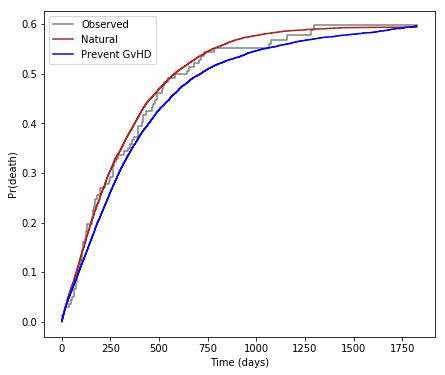

In [19]:
# Fitting Kaplan Meier for the prevent all GvHD data
gfn = g.predicted_outcomes.copy()
kmp = KaplanMeierFitter()
kmp.fit(durations=gfn['day'], event_observed=gfn['d'])

# Generating plot
plt.figure(figsize=(7,6))
plt.step(kmo.event_table.index, 1 - kmo.survival_function_, c='gray', 
         where='post', label='Observed')
plt.step(kmn.event_table.index, 1 - kmn.survival_function_, c='firebrick', 
         where='post', label='Natural')
plt.step(kmp.event_table.index, 1 - kmp.survival_function_, c='blue', 
         where='post', label='Prevent GvHD')
plt.xlabel('Time (days)')
plt.ylabel('Pr(death)')
plt.legend()
plt.show()

Finally, we can estimate the hazard ratio comparing our natural course results to the prevent-all GvHD counterfactual

In [22]:
# Setting up pandas dataframe for lifelines.CoxPHFitter
rfn = pd.DataFrame()  # Natural course data
rfn['event'] = gf['d']
rfn['time'] = gf['day']
rfn['exp'] = 1

rfp = pd.DataFrame()  # Creating df for CoxPHFitter
rfp['event'] = gfn['d']
rfp['time'] = gfn['day']
rfp['exp'] = 0
rf = rfn.append(rfp, ignore_index=True, sort=False)

cph = CoxPHFitter()
cph.fit(rf, duration_col='time', event_col='event')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 27400 observations, 11413 censored>
      duration col = 'time'
         event col = 'event'
number of subjects = 27400
  number of events = 15987
    log-likelihood = -157110.08
  time fit was run = 2019-05-07 12:30:15 UTC

---
     coef exp(coef)  se(coef)    z      p  -log2(p)  lower 0.95  upper 0.95
exp  0.06      1.06      0.02 3.74 <0.005     12.43        0.03        0.09
---
Concordance = 0.51
Log-likelihood ratio test = 14.01 on 1 df, -log2(p)=12.43


Our results match the ones shown in Keil et al. 2014. Due to time contrainsts, I will not bootstrap the confidence intervals here, but a bootstrapping procedure should be used for confidence intervals. The confidence intervals in the above output are invalid for the Monte-Carlo g-formula

# Conclusion
In this tutorial, we went piece-by-piece through the Monte-Carlo g-formula as described by Keil et al. 2014. With the papers details and available SAS code, this tutorial will hopefully serve as a useful Rosetta stone to `MonteCarloGFormula` in Python. 

## Further Reading
Keil AP et al. (2014). The parametric G-formula for time-to-event data: towards intuition with a worked example. *Epidemiology*, 25(6), 889.